# Projet LEYENDA
## Livrable 1 - Classification Binaire

# 1-Importation des bibliothèques
On va regrouper ici l'ensemble des bibliothèques que nous allons utiliser dans ce nootbook

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib
import zipfile
import keras

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from keras.src.layers.preprocessing.image_preprocessing import HORIZONTAL_AND_VERTICAL
from keras.src.layers.preprocessing.image_preprocessing import RandomFlip
from keras.src.layers.preprocessing.image_preprocessing import RandomRotation
from keras.src.layers.preprocessing.image_preprocessing import RandomZoom
from keras import Sequential

# 2-Préparation des images
#### Dézip des fichiers

In [20]:
repertoire = './DataL1'
dossier_dataset = './Data'
if not os.path.exists(dossier_dataset):
    os.makedirs(dossier_dataset)
    
for fichier in os.listdir(repertoire):
    chemin_fichier = os.path.join(repertoire,fichier)
    if zipfile.is_zipfile(chemin_fichier):
        with zipfile.ZipFile(chemin_fichier, 'r') as zip_ref:
            zip_ref.extractall(dossier_dataset)
            print(f'Fichier {fichier} décompressé dans le dossier Dataset.')
print('Tous les fichiers ZIP ont été décompressés dans le dossier Dataset')

Fichier Dataset Livrable 1 - Painting.zip décompressé dans le dossier Dataset.
Fichier Dataset Livrable 1 - Photo.zip décompressé dans le dossier Dataset.
Fichier Dataset Livrable 1 - Text.zip décompressé dans le dossier Dataset.
Fichier Dataset Livrable 1 - Sketch.zip décompressé dans le dossier Dataset.
Fichier Dataset Livrable 1 - Schematics.zip décompressé dans le dossier Dataset.
Tous les fichiers ZIP ont été décompressés dans le dossier Dataset


## Suppression des images corrompues

In [21]:
dataset_folder = dossier_dataset
print("Début de la vérification des images avec TensorFlow...")
for subdir, _, files in os.walk(dataset_folder):
    for file in files:
        file_path = os.path.join(subdir, file)
        try:
            # Tenter de charger et décoder l'image avec TensorFlow
            img = tf.io.read_file(file_path)
            img = tf.image.decode_image(img)
        except Exception as e:
            print(f"Image {file_path} is invalid for TensorFlow. Exception: {e}")
            try:
                os.remove(file_path)
                print(f"Removed: {file_path}")
            except Exception as e_rm:
                print(f"Error removing {file_path}. Exception: {e_rm}")

print("Vérification des images terminée.")

Début de la vérification des images avec TensorFlow...
Image ./Data/Schematics/desktop.ini is invalid for TensorFlow. Exception: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 
Removed: ./Data/Schematics/desktop.ini


2023-10-13 08:18:55.083914: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Image ./Data/Painting/painting_02662.jpg is invalid for TensorFlow. Exception: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input size should match (header_size + row_size * abs_height) but they differ by 2 [Op:DecodeImage] name: 
Removed: ./Data/Painting/painting_02662.jpg


Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


Vérification des images terminée.


#### Emplacement du dataset
On spécifie ensuite l'emplacement du dataset et on met en place la variable data_dir.

In [22]:
datapath = dossier_dataset
data_dir = pathlib.Path(datapath)

### Création des Set
Pour commencer, on spécifie quelques paramètres pour l'apprentissage :
<ul>
    <li>La longueur et la largeur des images. </li>
    <li>La taille du batch.</li>
</ul>
On crée maintenant nos deux sets, un d'entraînement (80% des data) et un de test (20% des data).

In [23]:
image_h = 180
image_w = 180
batch_s = 32

In [24]:
# Le train_set
train_set = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=  0.2,
    subset =  "training",
    seed=42,
    image_size=(image_h, image_w),
    batch_size=batch_s
)
# Le test_set
test_set = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=  0.2,
    subset =  "validation",
    seed=42,
    image_size=(image_h, image_w),
    batch_size=batch_s
)

Found 41398 files belonging to 5 classes.
Using 33119 files for training.
Found 41398 files belonging to 5 classes.
Using 8279 files for validation.


On en profite pour vérifier que les labels ont bien été trouvés :

In [25]:
class_names = train_set.class_names
print(class_names)

['Painting', 'Photo', 'Schematics', 'Sketch', 'Text']


# 3 - Coup d'œil sur nos données
On peut affichage une des images du set d'entraînements, aux dimensions spécifiées dans les paramètres :

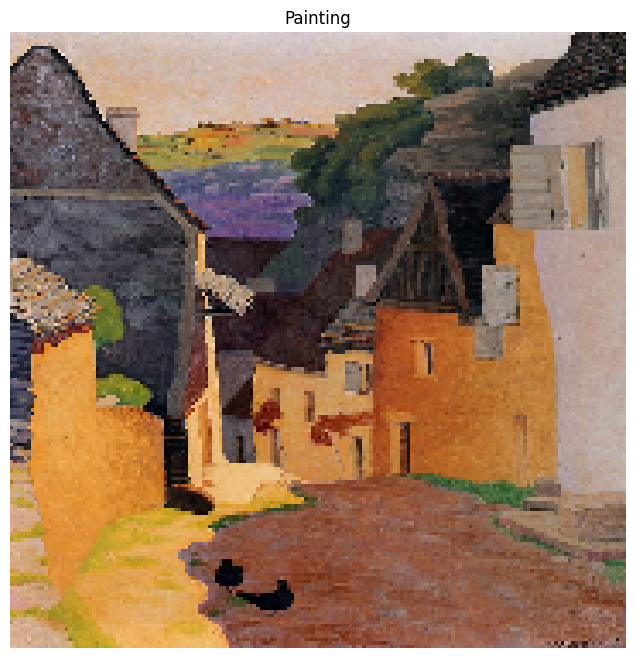

In [26]:
plt.figure(figsize=(8, 8))
for images, labels in train_set.take(1):
    for i in range(9):
        ax =  plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Il est maintenant temps de configurer notre environnement pour passer au vif du sujet.

# 3. Configuration de l'environnement pour l'entrainement
Dans cette partie, vous devrez utiliser les fonctions [`Dataset.cache`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) et [`Dataset.prefetch`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) afin de configurer les données pour améliorer les performances de la façon suivante :
- `Dataset.cache()` : Cette fonction sert à forcer le maintien des données en cache dans la mémoire. Vu que le réseau de neurones fait plusieurs passes (qu'on nomme _époque_ ou _epoch_ en anglais) sur les données durant l'apprentissage, cette fonction permet de ne pas avoir à recharger les images à chaque fois. 
- `Dataset.prefetch()` : Cette fonction permet de faire le prétraitement de l'élément courant du jeu de données (par exemple le batch suivant) en même temps que l'entrainement/évaluation du batch courant par le modèle. Dans un environnement multi-processeurs ou multi-cœur, c'est un gain de temps non négligeable.

In [27]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size=AUTOTUNE)

## Techniques de régularisation
Les techniques de régularisation sont les techniques qui visent à réduire le surapprentissage. L’objectif est d’éviter que le réseau de neurones mémorise le jeu de données en s’ajustant bêtement sur les particularités du jeu d’entrainement. Il s’agit globalement de réduire les degrés de liberté du réseau de neurones.

Les techniques de régularisation sont les techniques qui visent à réduire le surapprentissage. L’objectif est d’éviter que le réseau de neurones mémorise le jeu de données en s’ajustant bêtement sur les particularités du jeu d’entrainement. Il s’agit globalement de réduire les degrés de liberté du réseau de neurones. Dans le cadre de ce wokrshop nous verrons deux techniques de régularisation :
-	**L’augmentation des données** : Avoir plus de données est toujours bon pour réduire le surapprentissage, d’où l’augmentation des données. Le principe et de rajouter de nouvelles images en effectuant des transformations sur le jeu d’entrainement d’origine. Ces nouvelles images sont obtenues par des transformation affines, ou généralement par des transformations réalistes qui ne change pas la nature du label affectée à l’image. Cette technique est très efficace car les réseaux de neurones sont très gourmands en données.
-	**La technique de dropout** : Cette technique consiste à désactiver, à chaque traitement, les neurones d’une couche dense du réseau de manière aléatoire. Le dropout dépend d’un paramètre qui représente la probabilité de désactivation des neurones de la couche. Cette probabilité est le la proportion moyenne de neurones actives dans la couche durant les itérations de l’entrainement. Elle permet de réduire la complexité du réseau de neurones pour réduire le surapprentissage.

In [28]:
data_augmentation = Sequential(
    [
        RandomFlip(
            mode=HORIZONTAL_AND_VERTICAL,
            input_shape=(image_h, image_w, 3)),
        RandomRotation(
            factor=0.18,
            fill_mode='reflect',
            interpolation='bilinear',
            seed=None,
            fill_value=0.0),
        RandomZoom(
            height_factor=0.1,
            width_factor=None,
            fill_mode='reflect',
            interpolation='bilinear',
            seed=None,
            fill_value=0.0)
    ]
)

# 4. Réalisation d'un modèle CNN
On commence par crée la variable num_classes, elle sera égale au nombre de label que nous avons et sera utilisé pour déterminer le nombre de neurones sur la dernière couche.

In [29]:
num_classes = 5 # Nombre de classes et donc aussi nombre de neurones dans la dernière couche
callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, verbose=1,restore_best_weights=True)

On crée ensuite notre modèle en y implémentant l'ensemble des couches que nous souhaitons y intégrer :
- Un bloc convolutif contenant 16 filtres de hauteur et de largeur 3 avec une couche de Pooling.
- Un bloc convolutif similaire au précédent contenant 32 filtres de hauteur et de largeur de 3.
- Un bloc convolutif similaire au précédent contenant 64 filtres de hauteur et de largeur de 3.
- Une couche de DropOut
- Une couche contenant la couche précédente aplatie (flatten).
- Une couche entièrement connectée de taille 128.
- La couche finale complètement connectée (dense) retournant le résultat de la classification.

On peut ensuite compiler le modèle.

In [12]:
# Le modèle
epochs = 40
complete_model =  Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes) # 5 dans notre cas
])
complete_model.build((None, image_h, image_w, 3))
# Compilation du modèle
complete_model.compile(optimizer =  'adam',
                       loss =  tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                       metrics=['accuracy'])
# Résumé du modèle
complete_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 64)        18496     
                                                      

## Entrainement du modèle
Maintenant que l'on dispose d'un modèle, on va pouvoir l'entraîner puis tester le modèle avec notre jeu de test.

Epoch 1/40
1035/1035 [==============================] - 181s 174ms/step - loss: 0.3697 - accuracy: 0.8540 - val_loss: 0.4590 - val_accuracy: 0.8276
Epoch 2/40
1035/1035 [==============================] - 222s 214ms/step - loss: 0.4273 - accuracy: 0.8338 - val_loss: 0.4522 - val_accuracy: 0.8267
Epoch 3/40
1035/1035 [==============================] - 224s 217ms/step - loss: 0.3293 - accuracy: 0.8694 - val_loss: 0.4725 - val_accuracy: 0.8323
Epoch 4/40
1035/1035 [==============================] - 235s 226ms/step - loss: 0.3246 - accuracy: 0.8737 - val_loss: 0.4071 - val_accuracy: 0.8424
Epoch 5/40
1035/1035 [==============================] - 230s 222ms/step - loss: 0.3095 - accuracy: 0.8797 - val_loss: 0.4817 - val_accuracy: 0.8297
Epoch 6/40
1035/1035 [==============================] - 229s 222ms/step - loss: 0.3698 - accuracy: 0.8578 - val_loss: 0.6747 - val_accuracy: 0.7442
Epoch 7/40
1035/1035 [==============================] - 235s 227ms/step - loss: 0.3162 - accuracy: 0.8760 - val_

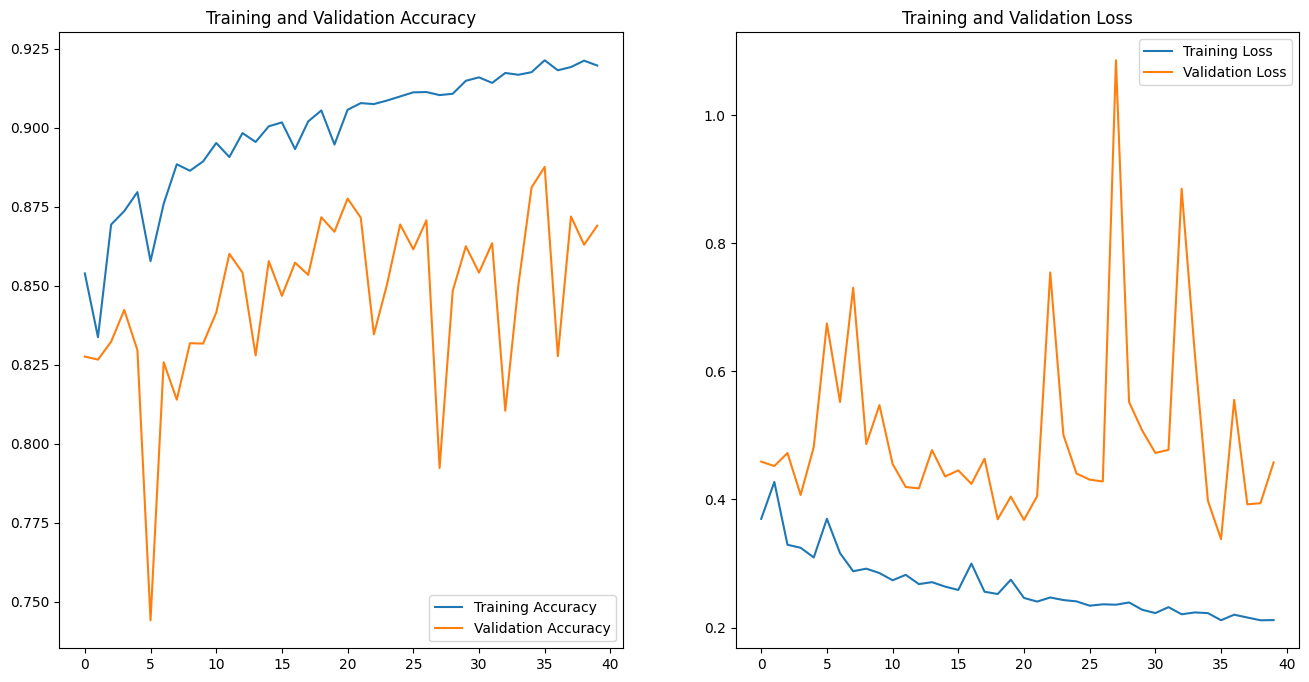

In [14]:
# Entrainement du modèle
modele1 =  complete_model.fit(
    train_set,
    validation_data=test_set,
    epochs=epochs,
)
acc = modele1.history['accuracy']
val_acc = modele1.history['val_accuracy']

loss = modele1.history['loss']
val_loss = modele1.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 6. Amélioration du modèle


## Deuxième modèle
Modification apportée au modèle :

-Augmentation de la profondeur du réseau avec une couche Conv2D supplémentaire.
-Augmentation des couches de MaxPooling.
-Ajout de couches Dropout.
-Utilisation de la fonction d'activation softmax car on est sur une classification multi-classe.
-Réduction du nombre de paramètres dans les couches Conv2D pour prévenire le surajustement.
-Augmentation de la taille de la couche Dense avant la sortie pour augmenter la capacité du modèle à apprendre des représentations complexes.

In [15]:
# Le modèle
epochs = 20
complete_model2 =  Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255, input_shape = (image_h, image_w,3)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation = "softmax") # 5 dans notre cas
])
complete_model2.build((None, image_h, image_w, 3))
# Compilation du modèle
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) # On utiliser un taux d'apprentissage adaptatif 
complete_model2.compile(optimizer =  'adam',
                        loss =  tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy'])
# Résumé du modèle
complete_model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                 

In [18]:
# Entrainement du modèle
modele2 =  complete_model2.fit(
    train_set,
    validation_data=test_set,
    epochs=epochs,
    #callbacks=[callback],
)

Epoch 1/20
1035/1035 [==============================] - 250s 241ms/step - loss: 0.3684 - accuracy: 0.8598 - val_loss: 0.3623 - val_accuracy: 0.8627
Epoch 2/20
1035/1035 [==============================] - 235s 227ms/step - loss: 0.3485 - accuracy: 0.8654 - val_loss: 0.3576 - val_accuracy: 0.8621
Epoch 3/20
1035/1035 [==============================] - 242s 234ms/step - loss: 0.3248 - accuracy: 0.8748 - val_loss: 0.4664 - val_accuracy: 0.8308
Epoch 4/20
1035/1035 [==============================] - 245s 237ms/step - loss: 0.3275 - accuracy: 0.8749 - val_loss: 0.3735 - val_accuracy: 0.8687
Epoch 5/20
1035/1035 [==============================] - 251s 243ms/step - loss: 0.3181 - accuracy: 0.8788 - val_loss: 0.3424 - val_accuracy: 0.8750
Epoch 6/20
1035/1035 [==============================] - 240s 232ms/step - loss: 0.3028 - accuracy: 0.8872 - val_loss: 0.3506 - val_accuracy: 0.8770
Epoch 7/20
1035/1035 [==============================] - 231s 223ms/step - loss: 0.2977 - accuracy: 0.8867 - val_

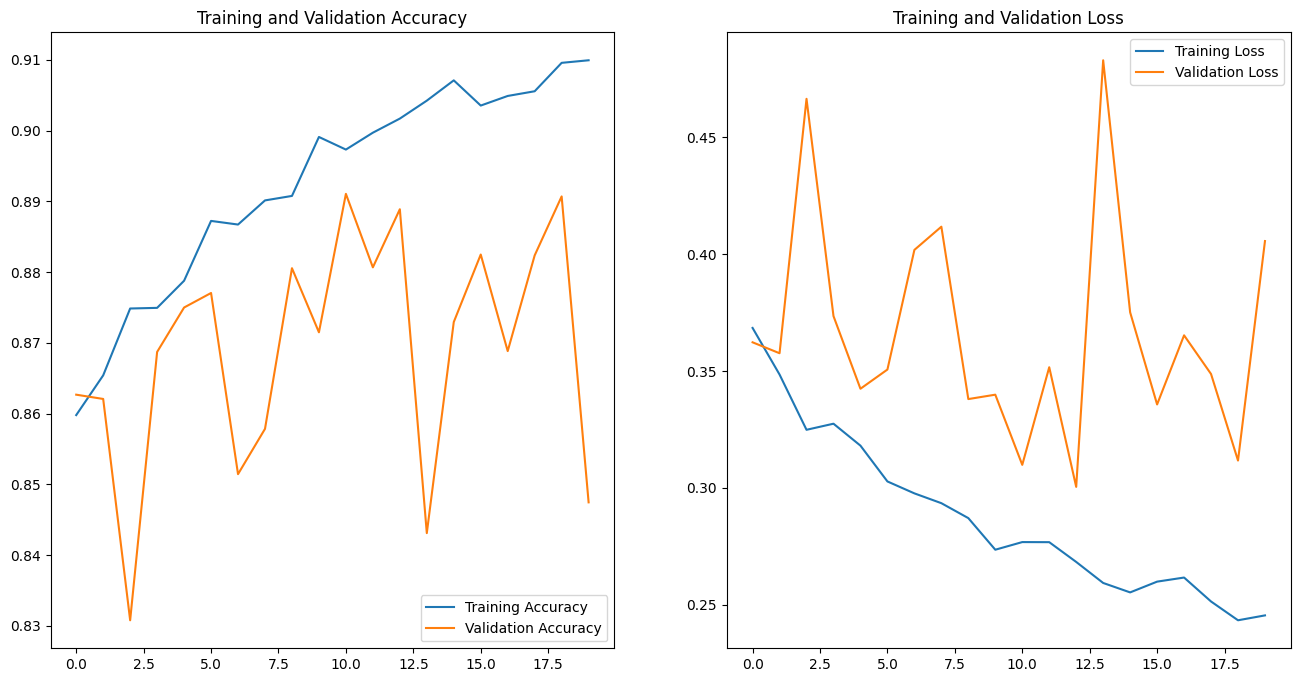

In [20]:
acc = modele2.history['accuracy']
val_acc = modele2.history['val_accuracy']

loss = modele2.history['loss']
val_loss = modele2.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Troisème modèle
Ce modèle ajoute plus de couches Conv2D et de MaxPooling pour augmenter la profondeur du réseau.

In [13]:
# Le modèle
epochs = 20
complete_model3 =  Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(image_h, image_w, 3)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax') # 5 dans notre cas
])
complete_model3.build((None, image_h, image_w, 3))
# Compilation du modèle
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) # On utiliser un taux d'apprentissage adaptatif 
complete_model3.compile(optimizer =  'adam',
                        loss =  tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy'])
# Résumé du modèle
complete_model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 90, 90, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 45, 45, 128)       0         
 g2D)                                                 

In [14]:
# Entrainement du modèle
modele3 =  complete_model3.fit(
    train_set,
    validation_data=test_set,
    epochs=epochs,
    #callbacks=[callback],
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-10-13 06:29:06.783815: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-10-13 06:29:16.894342: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 153 of 1000
2023-10-13 06:29:26.921877: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 297 of 1000
2023-10-13 06:29:36.938795: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Shuff

1035/1035 [==============================] - 265s 176ms/step - loss: 0.7372 - accuracy: 0.6924 - val_loss: 0.5431 - val_accuracy: 0.7860
Epoch 2/20
1035/1035 [==============================] - 217s 210ms/step - loss: 0.4871 - accuracy: 0.8027 - val_loss: 0.4353 - val_accuracy: 0.8179
Epoch 3/20
1035/1035 [==============================] - 186s 179ms/step - loss: 0.4292 - accuracy: 0.8258 - val_loss: 0.4490 - val_accuracy: 0.8153
Epoch 4/20
1035/1035 [==============================] - 187s 181ms/step - loss: 0.3950 - accuracy: 0.8442 - val_loss: 0.4049 - val_accuracy: 0.8485
Epoch 5/20
1035/1035 [==============================] - 183s 177ms/step - loss: 0.3605 - accuracy: 0.8588 - val_loss: 0.3866 - val_accuracy: 0.8493
Epoch 6/20
1035/1035 [==============================] - 178s 172ms/step - loss: 0.3395 - accuracy: 0.8668 - val_loss: 0.3946 - val_accuracy: 0.8509
Epoch 7/20
1035/1035 [==============================] - 192s 186ms/step - loss: 0.3269 - accuracy: 0.8729 - val_loss: 0.377

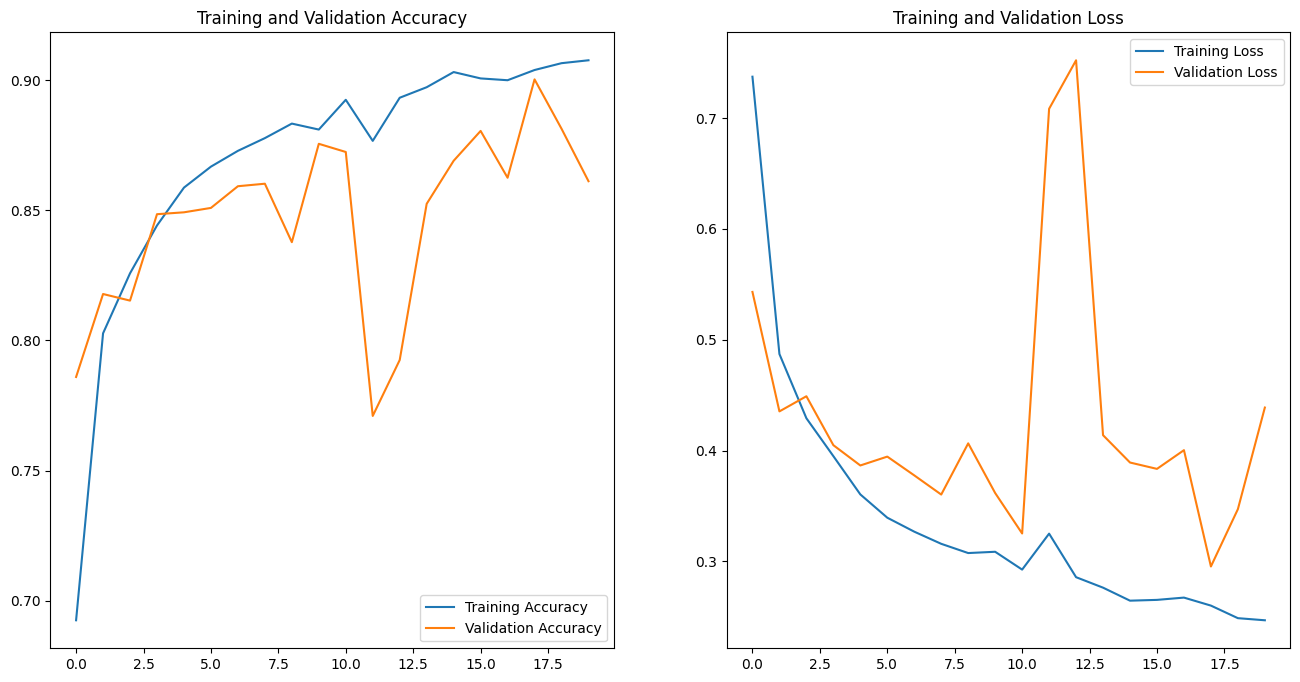

In [15]:
acc = modele3.history['accuracy']
val_acc = modele3.history['val_accuracy']

loss = modele3.history['loss']
val_loss = modele3.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Exportation du modèle

In [21]:
complete_model3.save("./TrainedModel/Model3epo20.keras")

## Lancement du modèle sur 100 epochs

In [ ]:
# Entrainement du modèle
modele3 =  complete_model3.fit(
    train_set,
    validation_data=test_set,
    epochs=100,
    callbacks=[callback],
)

In [ ]:
acc = modele3.history['accuracy']
val_acc = modele3.history['val_accuracy']

loss = modele3.history['loss']
val_loss = modele3.history['val_loss']

epochs_range = range(100)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# RGB vers Grayscale
Étant donné le temps important que prend notre dernier modèle, ont essayé de travailler avec des images en dégrader de gris et plus en couleur. Cela devrait permettre au modèle d'apprendre plus vite.

In [36]:
repertoire = './DataL1'
dossier_dataset = './Data'
if not os.path.exists(dossier_dataset):
    os.makedirs(dossier_dataset)

for fichier in os.listdir(repertoire):
    chemin_fichier = os.path.join(repertoire,fichier)
    if zipfile.is_zipfile(chemin_fichier):
        with zipfile.ZipFile(chemin_fichier, 'r') as zip_ref:
            zip_ref.extractall(dossier_dataset)
            print(f'Fichier {fichier} décompressé dans le dossier Dataset.')
print('Tous les fichiers ZIP ont été décompressés dans le dossier Dataset')

KeyboardInterrupt: 

In [ ]:
dataset_folder = dossier_dataset
print("Début de la vérification des images avec TensorFlow...")
for subdir, _, files in os.walk(dataset_folder):
    for file in files:
        file_path = os.path.join(subdir, file)
        try:
            # Tenter de charger et décoder l'image avec TensorFlow
            img = tf.io.read_file(file_path)
            img = tf.image.decode_image(img)
        except Exception as e:
            print(f"Image {file_path} is invalid for TensorFlow. Exception: {e}")
            try:
                os.remove(file_path)
                print(f"Removed: {file_path}")
            except Exception as e_rm:
                print(f"Error removing {file_path}. Exception: {e_rm}")

print("Vérification des images terminée.")

In [ ]:
# Le train_set
train_set = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=  0.2,
    subset =  "training",
    seed=42,
    image_size=(image_h, image_w),
    batch_size=batch_s
)
# Le test_set
test_set = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=  0.2,
    subset =  "validation",
    seed=42,
    image_size=(image_h, image_w),
    batch_size=batch_s
)

In [ ]:
train_set = train_set.map(lambda x, y: (tf.image.rgb_to_grayscale(x),y))
test_set = test_set.map(lambda x, y: (tf.image.rgb_to_grayscale(x),y))

In [ ]:
data_augmentation = Sequential(
    [
        RandomFlip(
            mode=HORIZONTAL_AND_VERTICAL,
            input_shape=(image_h, image_w, 1)),
        RandomRotation(
            factor=0.18,
            fill_mode='reflect',
            interpolation='bilinear',
            seed=None,
            fill_value=0.0),
        RandomZoom(
            height_factor=0.1,
            width_factor=None,
            fill_mode='reflect',
            interpolation='bilinear',
            seed=None,
            fill_value=0.0)
    ]
)

In [ ]:
# Le modèle
epochs = 50
complete_model4 =  Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax') # 5 dans notre cas
])
complete_model4.build((None, image_h, image_w, 1))
# Compilation du modèle
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) # On utiliser un taux d'apprentissage adaptatif 
complete_model4.compile(optimizer =  'adam',
                        loss =  tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy'])
# Résumé du modèle
complete_model4.summary()

In [ ]:
# Entrainement du modèle
modele4 =  complete_model4.fit(
    train_set,
    validation_data=test_set,
    epochs=epochs,
    #callbacks=[callback],
)

In [ ]:
acc = modele4.history['accuracy']
val_acc = modele4.history['val_accuracy']

loss = modele4.history['loss']
val_loss = modele4.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
complete_model4.save("./TrainedModel/Model4epo50.keras")